In [107]:
# 기본 데이터 정리 및 처리
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import json
import sklearn
import re

# 시각화
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas_profiling

# 전처리 및 머신 러닝 알고리즘
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_tree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# 모델 튜닝 및 평가
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection
import gc

from sklearn.compose import make_column_selector
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report 

# 경고 제거 (판다스가 에러 메세지를 자주 만들어 내기 때문에 이를 일단 무시하도록 설정합니다.)
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
if False:
    df_train_path = '../input/sf-crime/train.csv'
    df_test_path = '../input/sf-crime/test.csv'

    def csv_to_parquet(csv_path, save_name):
        df = pd.read_csv(csv_path)
        df.to_parquet(f'./{save_name}.parquet')
        del df
        gc.collect()
        print(save_name, 'Done.')

    csv_to_parquet(df_train_path, '../input/sf-crime/train')
    csv_to_parquet(df_test_path, '../input/sf-crime/test')

df_train_path = '../input/sf-crime/train.parquet'
df_test_path = '../input/sf-crime/test.parquet'

df_train_ = pd.read_parquet(df_train_path)
df_train = df_train_.copy()
df_test_ = pd.read_parquet(df_test_path)
df_test = df_test_.copy()


In [63]:
df_train_.head(1)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599


In [64]:
df_test_.head(1)

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051


In [5]:
df_train.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
df_test.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
print('before drop_duplicates:', df_train.shape)
df_train.drop_duplicates(inplace=True)
print('after drop_duplicates:', df_train.shape)


before drop_duplicates: (878049, 9)
after drop_duplicates: (875726, 9)


In [4]:
df_train = df_train.drop(['Descript', 'Resolution'], axis=1)
df_train.shape

(875726, 7)

In [10]:
print('before bad location drop:', df_train.shape)
df_train = df_train[df_train['Y'] < 90]
print('after bad location drop:', df_train.shape)

before bad location drop: (875726, 9)
after bad location drop: (875659, 9)


<AxesSubplot:xlabel='X', ylabel='Y'>

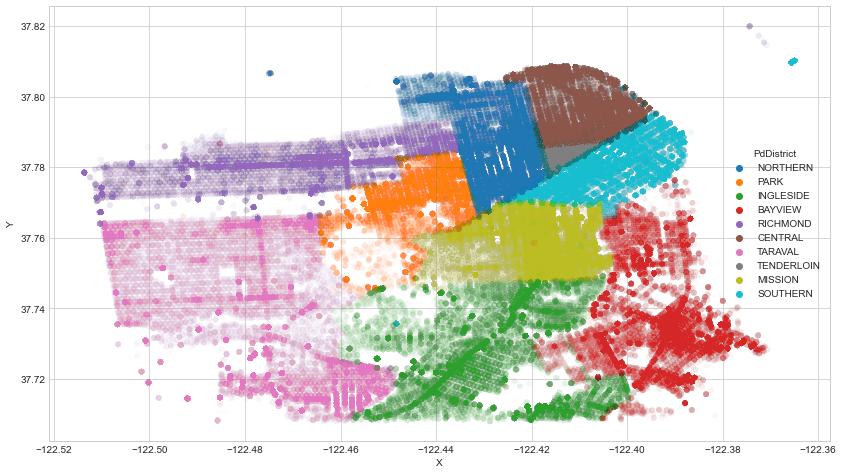

In [12]:
fig, ax = plt.subplots(figsize=(14,8))
sns.scatterplot(x='X', y='Y', data=df_train, alpha=.01, hue='PdDistrict', ax=ax)



In [13]:
df_train.dtypes

Dates          object
Category       object
DayOfWeek      object
PdDistrict     object
Address        object
X             float64
Y             float64
dtype: object

In [14]:
df_train['Dates'] = pd.to_datetime(df_train['Dates'])
df_train['Dates'].head(3)

0   2015-05-13 23:53:00
1   2015-05-13 23:53:00
2   2015-05-13 23:33:00
Name: Dates, dtype: datetime64[ns]

In [17]:
df_train['Date'] = df_train['Dates'].dt.date
df_train['Hour'] = df_train['Dates'].dt.hour
df_train['Date']

0         2015-05-13
1         2015-05-13
2         2015-05-13
3         2015-05-13
4         2015-05-13
             ...    
878044    2003-01-06
878045    2003-01-06
878046    2003-01-06
878047    2003-01-06
878048    2003-01-06
Name: Date, Length: 875659, dtype: object

In [22]:
df_train['Dates'].dt.day_of_week

0         2
1         2
2         2
3         2
4         2
         ..
878044    0
878045    0
878046    0
878047    0
878048    0
Name: Dates, Length: 875659, dtype: int64

In [20]:
df_train.groupby('Date').count().iloc[:,0]

Date
2003-01-06    400
2003-01-07    417
2003-01-08    523
2003-01-09    416
2003-01-10    397
             ... 
2015-05-02    376
2015-05-03    375
2015-05-11    425
2015-05-12    330
2015-05-13    362
Name: Dates, Length: 2249, dtype: int64

In [87]:
df_train_.dtypes

Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

In [97]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline

class columnDropperTransformer():
    def __init__(self, cols_to_del):
        self.cols_to_del = cols_to_del
    
    def transform(self, X, y=None):
        for col in self.cols_to_del:
            if col in X.columns:
                X = X.drop(col, axis=1)
        return X

    def fit(self, X, y=None):
        return self

In [121]:
cols_to_del = ['Dates', 'Category', 'Descript', 'Resolution', 'Id', 'Address']
cols_to_onehot = ['PdDistrict']
num_columns = list(set(df_train.columns) - set(df_train.select_dtypes(include=['object']).columns.tolist()))

del_pipeline = Pipeline([
    ('column_dropper', columnDropperTransformer(cols_to_del))
])
num_pipeline = Pipeline([
    ('scaler', MinMaxScaler())
])
main_pipeline = ColumnTransformer([
    # ('delete', del_pipeline, make_column_selector()),
    ('number', num_pipeline, num_columns),
    ('category', OneHotEncoder(), cols_to_onehot),
])

In [140]:
def preprocessing(df_, flag_train=True):
    df = df_.copy()
    df = df.drop_duplicates()

    if flag_train:
        target = df['Category']

    df['Dates'] = pd.to_datetime(df['Dates'])
    # df['Date'] = pd.to_datetime(df['Dates'].dt.date)
    df['DayOfWeek'] = df['Dates'].dt.weekday
    df['Month'] = df['Dates'].dt.month
    df['Year'] = df['Dates'].dt.year
    df['Hour'] = df['Dates'].dt.hour

    # delete not-used columns
    cols_to_del = ['Dates', 'Category', 'Descript', 'Resolution', 'Id', 'Address']

    for col in cols_to_del:
        if col in df.columns:
            df = df.drop(col, axis=1)
    
    if flag_train:
        return df, target
    else: return df

In [144]:
# num_columns = list(set(df_train.columns) - set(df_train.select_dtypes(include=['object']).columns.tolist()))
# num_columns
df_train, y = preprocessing(df_train_, flag_train=True)
df_test = preprocessing(df_test_, flag_train=False)
X = main_pipeline.fit_transform(df_train)
X_test = main_pipeline.transform(df_test)

le = LabelEncoder()
y = le.fit_transform(y)

In [146]:
X.shape, y.shape

((875726, 16), (875726,))

In [147]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True) # stratify=target, 

In [149]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

lgc = LGBMClassifier()
lgc.fit(X_train, y_train)
preds = lgc.predict(X_val)

In [150]:
precision_score(y_val, preds, average='micro'), recall_score(y_val, preds, average='micro')

(0.246313923958124, 0.246313923958124)

In [170]:

class MultiScorer():
	'''
	Use this class to encapsulate and/or aggregate multiple scoring functions so that it can be passed as an argument for scoring in scikit's cross_val_score function.
	Instances of this class are also callables, with signature as needed by `cross_val_score`.
	'''

	def __init__(self, metrics):
		'''
		Create a new instance of MultiScorer.
		Parameters
		----------
		metrics: dict
			The metrics to be used by the scorer.
			The dictionary must have as key a name (str) for the metric and as value a tuple containing the metric function itself and a dict literal of the additional named arguments to be passed to the function.
			The metric function should be one of the `sklearn.metrics` function or any other callable with the same signature: `metric(y_real, y, **kwargs)`.
		'''

		self.metrics = metrics
		self.results = {}
		self._called = False
		self.n_folds = 0

		for metric in metrics.keys():
			self.results[metric] = []



	def __call__(self, estimator, X, y):
		'''
		To be called by for evaluation from sklearn's GridSearchCV or cross_val_score.
		Parameters are as they are defined in the respective documentation.
		Returns
		-------
			A dummy value of 0.5 just for compatibility reasons.
		'''

		self.n_folds += 1
		yPred = estimator.predict(X)

		for key in self.metrics.keys():
			metric, kwargs = self.metrics[key]

			self.results[key].append(metric(y, yPred, **kwargs))

		self._called = True

		return 0.5

	def get_metric_names(self):
		'''
		Get all the metric names as given when initialized
		Returns
		-------
		A list containing the given names (str) of the metrics
		'''

		return self.metrics.keys()

	def get_results(self, metric=None, fold='all'):
		'''
		Get the results of a specific or all the metrics.
		This method should be called after the object itself has been called so that the metrics are applied.
		Parameters
		----------
		metric: str or None (default)
			The given name of a metric to return its result(s). If omitted the results of all metrics will be returned.
		fold: int in range [1, number_of_folds] or 'all' (Default)
		 	Get the metric(s) results for the specific fold.
			The number of folds corresponds to the number of times the instance is called.
			If its value is a number, either the score of a single metric for that fold or a dictionary of the (single) scores for that fold will be returned, depending on the value of `metric` parameter.
			If its value is 'all', either a list of a single metric or a dictionary containing the lists of scores for all folds will be returned, depending on the value of `metric` parameter.
		Returns
		-------
		metric_result_for_one_fold
			The result of the designated metric function for the specific fold, if `metric` parameter was not omitted and an integer value was given to `fold` parameter.
			If  the value of `metric` does not correspond to a metric name, `None` will be returned.
		all_metric_results_for_one_fold: dict
			A dict having as keys the names of the metrics and as values their results for the specific fold.
			This will be returned only if `metric` parameter was omitted and an integer value was given to `fold` parameter.
		metric_results_for_all_folds: list
			A list of length number_of_folds containing the results of all folds for the specific metric, if `metric` parameter was not omitted and value 'all' was given to `fold`.
			If  the value of `metric` does not correspond to a metric name, `None` will be returned.
		all_metric_results_for_all_folds: dict of lists
			A dict having as keys the names of the metrics and as values lists (of length number_of_folds) of their results for all folds.
			This will be returned only if `metric` parameter was omitted and 'all' value was given to `fold` parameter.
		Raises
		------
		UserWarning
			If this method is called before the instance is called for evaluation.
		ValueError
			If the value for `fold` parameter is not appropriate.
		'''

		if not self._called:
			raise UserWarning('Evaluation has not been performed yet.')


		if isinstance(fold, str) and fold == 'all':

			if metric is None:
				return self.results
			else:
				return self.results[metric]

		elif isinstance(fold, int):

			if fold not in range(1, self.n_folds+1): raise ValueError('Invalid fold index: '+str(fold))

			if metric is None:
				res = dict()

				for key in self.results.keys():
					res[key] = self.results[key][fold-1]

				return res

			else:
				return self.results[metric][fold-1]
		else:
			raise ValueError('Unexpected fold value: %s' %(str(fold)))

In [172]:
# from multiscorer import MultiScorer
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score          
from sklearn.model_selection import cross_val_score
from numpy import average

scorer = MultiScorer({
    'Accuracy'  : (accuracy_score , {}),
    'Precision' : (precision_score, {'pos_label': 3, 'average':'macro'}),
    'Recall'    : (recall_score   , {'pos_label': 3, 'average':'macro'})
})

models = [LGBMClassifier()]
for model in models:
    _ = cross_val_score(model, X, y, scoring=scorer, cv=10, n_jobs=-1)
    results = scorer.get_results()

    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        print('%s : %f' % (metric_name, average_score))


KeyboardInterrupt: 

In [163]:
np.sum(y_val==preds)

53926

In [155]:
y_test_pred = lgc.predict(X_test)
preds_txt = le.inverse_transform(y_test_pred)
df_result = df_test_[['Id']]
for elem in le.classes_:
    df_result[elem] = 0
for i, pred in enumerate(tqdm(preds_txt)):
    df_result.iloc[i][pred] = 1
    
df_result.to_csv('../input/sf-crime/sf-crime-submission.csv', index=False)

100%|██████████| 884262/884262 [01:32<00:00, 9527.50it/s] 


In [160]:
df_result.to_csv('../input/sf-crime/sf-crime-submission.csv', index=False)

In [ ]:
# def preprocessing(df_, oe=None, sc=None):
#     if oe is None:
#         flag_train = True
#     else: flag_train = False

#     df = df_.copy()
#     df = df.drop_duplicates()

#     if flag_train:
#         le = LabelEncoder()
#         target = df['Category']
#         target = le.fit_transform(target)
    
#         sc = MinMaxScaler()
#         df[['X', 'Y']] = sc.fit_transform(df[['X', 'Y']])
#     else:
#         df[['X', 'Y']] = sc.transform(df[['X', 'Y']])
    
#     # delete not-used columns
#     cols_to_del = ['Category', 'Descript', 'Resolution', 'Id', 'Address']
#     for col in cols_to_del:
#         if col in df.columns:
#             df = df.drop(col, axis=1)

#     df['Dates'] = pd.to_datetime(df['Dates'])
#     # df['Date'] = pd.to_datetime(df['Dates'].dt.date)
#     df['DayOfWeek'] = df['Dates'].dt.weekday
#     df['Month'] = df['Dates'].dt.month
#     df['Year'] = df['Dates'].dt.year
#     df['Hour'] = df['Dates'].dt.hour
#     df = df.drop('Dates', axis=1)
    
#     # cat_columns = df.select_dtypes(include=['object']).columns.tolist()
#     cat_columns = ['PdDistrict']
#     df_c = df[cat_columns]
#     df = df.drop(cat_columns, axis=1)
#     if oe is None:
#         oe = OrdinalEncoder()
#         df_c = oe.fit_transform(df_c)
#     else:
#         df_c = oe.transform(df_c)
#     df_c = pd.DataFrame(df_c, columns=cat_columns, index=df.index)

#     for col in cat_columns:
#         df[col+'_num'] = df_c[col].astype('category')
    
#     cols_int2cat = ['DayOfWeek', 'Month', 'Year', 'Hour']
#     for col in cols_int2cat:
#         df[col] = df[col].astype('category')

#     if flag_train:
#         return df, target, oe, le, sc
#     else:
#         return df

In [ ]:
# df_train, target, oe, le, sc = preprocessing(df_train_)
# df_test = preprocessing(df_test_, oe, sc)

In [91]:
df_train.shape, target.shape

((875726, 7), (875726,))

In [92]:
from lightgbm import LGBMClassifier
import lightgbm as lgb


lgc = LGBMClassifier()
lgc.fit(df_train, target)
preds = lgc.predict(df_test)

KeyboardInterrupt: 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train, target, test_size=0.25, stratify=target, shuffle=True) # 

In [ ]:
lgc.fit(X_train, y_train)
y_pred = lgc.predict(X_val)

In [ ]:
precision_score(y_val, y_pred, average='micro'), recall_score(y_val, y_pred, average='micro')

(0.10977837867465697, 0.10977837867465697)

In [ ]:
np.sum(y_val==y_pred)

24034

In [151]:
preds_txt = le.inverse_transform(preds)
preds_txt

array(['OTHER OFFENSES', 'LARCENY/THEFT', 'BURGLARY', ..., 'PROSTITUTION',
       'LARCENY/THEFT', 'OTHER OFFENSES'], dtype=object)

In [152]:
df_result = df_test_[['Id']]
for elem in le.classes_:
    df_result[elem] = 0

In [158]:
from multiprocessing import *
import multiprocessing.sharedctypes as sharedctypes
import ctypes

manager = Manager()
ns = manager.Namespace()
ns.df = df_result

n_jobs = 10
def put_result(i_proc):
    i_start = int(i_proc * len(preds_txt)/n_jobs)
    i_end = int((i_proc + 1) * len(preds_txt)/n_jobs)
    for i in range(i_start, i_end):
        ns.df.iloc[i][preds_txt[i]] = 1

procs = [Process(target=put_result, args=[i]) for i in range(n_jobs)]
for proc in procs:
    proc.start()
for proc in procs:
    proc.join()
df_result = ns.df

In [ ]:
from tqdm import tqdm

for i, pred in enumerate(tqdm(preds_txt)):
    df_result.iloc[i][pred] = 1
    
df_result.to_csv('../input/sf-crime/sf-crime-submission.csv', index=False)

100%|██████████| 884262/884262 [00:25<00:00, 34656.56it/s]


In [153]:
result_arr = df_result.values
for i, pred in enumerate(tqdm(preds)):
    df_result.iloc[i][pred+1] = 1
df_result[:] = result_arr
df_result

100%|██████████| 218932/218932 [00:06<00:00, 33767.41it/s]


,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884257,884257,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
884258,884258,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
884259,884259,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
884260,884260,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [168]:
def lgbm_bo(n_estimators,max_depth, subsample):

    lgbm_params = {
        'n_estimators' : int(round(40)),
        'max_depth' : int(round(1)),
        'subsample' : int(round(1)),      
    }
    lgbm = LGBMClassifier(**lgbm_params)
    # X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2)
    lgbm.fit(X_train,y_train, 
        eval_set = [(X_train, y_train), (X_valid, y_valid)],
        eval_metric='accuracy'
    )
    precision_score(y_valid, y_pred, average='micro')

    return score

In [169]:
lgbm_parameter_bounds = {
    'n_estimators' : (30,100),
    'max_depth' : (1,3), # 나무의 깊이
    'subsample' : (0.5,1)
}
BO_lgbm = BayesianOptimization(f=lgbm_bo, pbounds=lgbm_parameter_bounds, random_state=0)

# Bayesian Optimization을 실행해보세요
BO_lgbm.maximize(init_points=5, n_iter=5)

# 튜닝된 파라미터를 바탕으로 test 데이터 셋 예측
#학습
lgbm_tune = LGBMClassifier(n_estimators=43 ,max_depth=3, subsample = 1)
lgbm_tune.fit(X,y)

|   iter    |  target   | max_depth | n_esti... | subsample |
-------------------------------------------------------------


LightGBMError: Multiclass objective and metrics don't match

In [ ]:
lgbm_params = {
    'n_estimators' : int(round(40)),
    'max_depth' : int(round(1)),
    'subsample' : int(round(1)),      
}
lgbm = LGBMClassifier(**lgbm_params)
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2)
lgbm.fit(X_train,y_train, 
    eval_set = [(X_train, y_train), (X_valid, y_valid)],
    eval_metric='accuracy'
)

ValueError: y contains previously unseen labels: [10]